In [1]:
import torch
import json
import numpy as np
from random import randint

import pandas as pd
import matplotlib.pyplot as plt

from transformers import OPTForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR



from data_utils import (
    load_glue_datasets,
    load_hans_dataset,
    load_paws_qqp_dataset,
)
from context_utils import create_few_shot_context, select_demonstrations

In [2]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Tokenizer + Models

In [3]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m") # tokenizer
teacher_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # teacher model
student_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # student model


# tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m") # tokenizer
# teacher_model = OPTForCausalLM.from_pretrained("facebook/opt-350m") # teacher model
# student_model = OPTForCausalLM.from_pretrained("facebook/opt-350m") # student model

## Datasets

In [4]:
data_set_used='mnli'
datasets, labels, num_labels = load_glue_datasets(data_set_used)

if data_set_used in ['mnli', 'rte', 'hans']:
    teacher_prompt = 'Think logically. Are the following sentences examples of entailment, yes or no?'
    student_prompt = 'Are the following sentences examples of entailment, yes or no?'
elif data_set_used in ['qqp', 'paws-qqp']:
    teacher_prompt = 'Think logically. Are the following sentences duplicates or paraphrases of each other, yes or no?'
    student_prompt = 'Are the following sentences duplicates or paraphrases of each other, yes or no?'

In [5]:
def create_train_batch_token(
    dataset_name,
    datasets,
    tokenizer,
    num_shots=16,
    device = 'cpu',
    num_sets=15,
    teacher_descr=teacher_prompt,
    student_descr=student_prompt
):
    datasets = datasets['train']
    
    batch_tokens = []
    batch_strings = []
    
    all_indices = []
    seed_nums = [randint(0, 1000) for i in range(num_sets)]
    for sn in seed_nums:
        # Randomly select demonstrations
        demonstrations, indices = select_demonstrations(
            datasets,
            balanced=True,
            rand_subset=True,
            num_shots=num_shots,
            seed=sn,
        )
        context, student_context = create_few_shot_context(
            dataset_name,
            demonstrations,
            datasets.features['label'],
            teacher_description=teacher_descr,
            student_description=student_descr,
        )
        token_data= {
            'context':(tokenizer(context, return_tensors="pt")).to(device),
            'query':(tokenizer(student_context, return_tensors="pt")).to(device)
        }
        string_data = {
            'context':context,
            'query':student_context
        }
        batch_tokens.append(token_data)
        batch_strings.append(string_data)
        all_indices.extend(indices)
        
        # Select demonstrations by index and shuffle them
        shuffled_demo, _ = select_demonstrations(
            datasets,
            shuffle=True,
            from_idxlabels=indices,
        )
        shuffled_context, shuffled_student_context = create_few_shot_context(
            dataset_name,
            shuffled_demo,
            datasets.features['label'],
            teacher_description=teacher_descr,
            student_description=student_descr,
        )
        token_data= {
            'context':(tokenizer(shuffled_context, return_tensors="pt")).to(device),
            'query':(tokenizer(shuffled_student_context, return_tensors="pt")).to(device)
        }
        string_data = {
            'context':shuffled_context,
            'query':shuffled_student_context
        }
        batch_tokens.append(token_data)
        batch_strings.append(string_data)
        all_indices.extend(indices)
    
    return batch_tokens, batch_strings, all_indices

def create_validation_batch_token(
    dataset_name,
    datasets,
    tokenizer,
    device = 'cpu',
    prompt_descr=student_prompt,
    limit=10
):
    if dataset_name == 'mnli':
        split = 'validation_matched'
    else:
        split = 'validation'
        
    datasets = datasets[split]
    
    demonstrations, all_indices = select_demonstrations(datasets)
    batch_tokens = []
    batch_strings = []
    for dx in range(limit):
        context, _ = create_few_shot_context(
            dataset_name,
            [demonstrations[dx]],
            demonstrations.features['label'],
            teacher_description=prompt_descr,
            remove_label=True
        )
        token_data = (tokenizer(context, return_tensors="pt")).to(device)
        batch_tokens.append(token_data)
        batch_strings.append(context)

    labels = [datasets['label'][datasets['idx'].index(i)] for i in all_indices]
    labels = datasets.features['label'].int2str(labels)
    return batch_tokens, batch_strings, all_indices[:limit],labels[:limit]

In [6]:
train_data_tokens, train_data_strings, _ = create_train_batch_token(
    data_set_used, datasets,num_shots=32, num_sets= 100, tokenizer=tokenizer, device=device
)

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

In [7]:
# Assuming `losses` is the list of epoch losses returned from the `train` function
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

Epoch 1, Total Loss: 2.2245588208703944
Epoch 2, Total Loss: 0.09710878488355472
Epoch 3, Total Loss: 0.08292920537739217
Epoch 4, Total Loss: 0.06898965930304257
Epoch 5, Total Loss: 0.06268422211966633
Epoch 6, Total Loss: 0.04673957391302489
Epoch 7, Total Loss: 0.042739841121753365
Epoch 8, Total Loss: 0.037055382229785515
Epoch 9, Total Loss: 0.03467955064843409
Epoch 10, Total Loss: 0.027357904245339643
Epoch 11, Total Loss: 0.030534177868200157
Epoch 12, Total Loss: 0.029926546742596354
Epoch 13, Total Loss: 0.030800391535497813
Epoch 14, Total Loss: 0.03039306396628187
Epoch 15, Total Loss: 0.02854930973990122
Epoch 16, Total Loss: 0.033171677839466916
Epoch 17, Total Loss: 0.02715802426124962
Epoch 18, Total Loss: 0.026925244973729907
Epoch 19, Total Loss: 0.024323409922847834
Epoch 20, Total Loss: 0.026655088205491968
Epoch 21, Total Loss: 0.024395784289178362
Epoch 22, Total Loss: 0.027897318665054627
Epoch 23, Total Loss: 0.028500372331109247
Epoch 24, Total Loss: 0.0308567

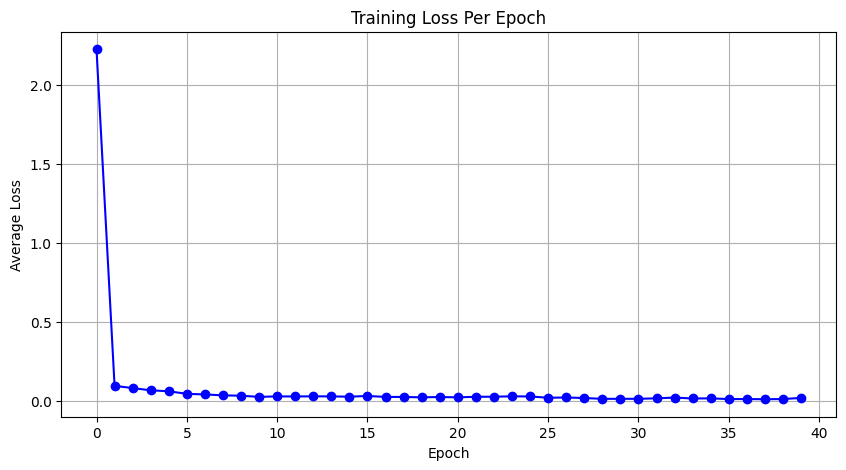

In [8]:
def train(data, epochs=10, batch_size=32, device='cpu'):
    student_model.to(device)
    teacher_model.to(device)
    
    student_model.train()
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5, weight_decay=0.000001 )
    epoch_losses = []

    num_batches = (len(data) // batch_size) + 1
    num_datapoints = len(data)
    total_steps = num_batches * epochs
    warmup_ratio = int(0.1 * total_steps) 
    
    def lr_schedular(current_step: int):
        if current_step < warmup_ratio:
            return float(current_step) / float(max(1,warmup_ratio))
        return 1.
    
    scheduler = LambdaLR(optimizer, lr_schedular)

    for epoch in range(epochs):
        total_loss = 0
        samples_left = num_datapoints
        
        for i in range(num_batches):
            batch_loss = 0
            if ((samples_left - batch_size) >= 0):
                samples_used = batch_size
                samples_left -= batch_size
            else:
                samples_used = samples_left
                samples_left = 0
            for j in range(samples_used):
                index = i * batch_size + j
                
                teacher_inputs = data[index]['context'].to(device)
                student_inputs = data[index]['query'].to(device)
                                
                teacher_outputs = teacher_model.generate(
                    **teacher_inputs,
                    max_length=teacher_inputs['input_ids'].shape[-1] + 1,
                    output_scores=True,
                    return_dict_in_generate=True
                )
                teacher_probs = torch.nn.functional.softmax(teacher_outputs.scores[0], dim=-1)
                
                student_logits = student_model(**student_inputs).logits
                student_probs = torch.nn.functional.softmax(student_logits[:, -1, :], dim=-1)
                
                kl_divergence = torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
                
                optimizer.zero_grad()
                kl_divergence.backward()
                optimizer.step()

                batch_loss += kl_divergence.item()

            # Average loss for the batch
            batch_loss /= batch_size
            total_loss += batch_loss
            scheduler.step()
            # print(f"Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {batch_loss}")


        # Average loss for the epoch
        epoch_loss = total_loss / num_batches
        epoch_losses.append(epoch_loss)

        print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss}")
        
    print(f"Total loss : {total_loss/epochs}")
    plot_losses(epoch_losses)
    # torch.save(student_model, './models/student.pth')


train(train_data_tokens, epochs = 40, device=device)


In [9]:
def predict(model, source, target=None, device='cpu'):
    predict = []
    for token in source:
        output = model.generate(**token, max_length=token['input_ids'].shape[-1] + 1).to(device)
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        predicted_label = decoded_output.split("Label:")[-1].strip().split('.')[0].strip()
        predict.append(predicted_label)
        
    return predict


student_prompt_tokens, student_prompt_strings, all_indices, all_labels = create_validation_batch_token(
    data_set_used, datasets, tokenizer=tokenizer, device=device, limit=100
)
prediction = predict(student_model, student_prompt_tokens, device=device)  



In [10]:
accuracy_score(prediction,all_labels)

0.59